# Dependencies

In [ ]:
!pip install emoji
!pip install wordcloud matplotlib

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import nltk
import emoji
nltk.download("stopwords")
nltk.download("punkt")
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings("ignore")

I found the following dataset via Kaggle (this is the best dataset I came across). Unfortunetly, there's not that much Nike data available online or without paying some money. It is important to understand that when working with existing sample datasets, there are often limitations on what additional data can be appened or changed.

**Nike Shoe Reviews**

Kaggle dataset: https://www.kaggle.com/datasets/amokunridwan/nike-shoe-reviews

This dataset is a valuable resource for businesses wanting to understand customers' feedback on their products. The data can be used to identify areas where the effects can be improved, as well as to develop marketing and sales strategies that are tailored to the needs of the customers.

# Loading Data

The Kaggle data was modified to have a more complete analysis and predictive accuracies.

Dropping RAND column. I created this column in Excel (using RAND()) to randomly assign "Male", "Female", and "Prefer not to say" values to each "User". Finally, I ended up having a new column called "Gender". Also, for predictive modeling purposes I decided to create and add new columns "IS_BEST_SELLER" and "IS_IN_STOCK".

In [ ]:
consumer_data = pd.read_csv("Nike_Consumer.csv")
consumer_data.drop(["RAND"], axis = 1, inplace = True)
#consumer_data.head()

In [ ]:
consumer_data = consumer_data[consumer_data["Location"] != "UK"] # excluding the UK rows (just 8)

# Exploratory Data Analysis

In [ ]:
consumer_data.info() # getting information about the dataframe structure and information.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4579 entries, 0 to 4586
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  4579 non-null   int64  
 1   Rating              4542 non-null   float64
 2   Review Date         4542 non-null   object 
 3   Location            4579 non-null   object 
 4   Username            4579 non-null   object 
 5   Member              4579 non-null   object 
 6   Gender              4579 non-null   object 
 7   Review              4579 non-null   object 
 8   Fit Feedback        407 non-null    object 
 9   Comfort Feedback    407 non-null    object 
 10  Recommend Feedback  407 non-null    object 
 11  Title               4579 non-null   object 
 12  IsPromoReview       4579 non-null   bool   
 13  Subtitle            4579 non-null   object 
 14  ColorDescription    4579 non-null   object 
 15  FullPrice           4579 non-null   int64  
 16  Discou

In [ ]:
missing_values = consumer_data.isnull().sum() # checking for missing values
print("Number of missing values within Nike's consumer data: ", missing_values)

Number of missing values within Nike's consumer data:  ID                       0
Rating                  37
Review Date             37
Location                 0
Username                 0
Member                   0
Gender                   0
Review                   0
Fit Feedback          4172
Comfort Feedback      4172
Recommend Feedback    4172
Title                    0
IsPromoReview            0
Subtitle                 0
ColorDescription         0
FullPrice                0
Discounted               0
EmployeePrice            0
CurrentPrice             0
IsLaunch                 0
Pid                      0
IS_BEST_SELLER           0
IS_IN_STOCK              0
dtype: int64


Filling feedback missing values with "No Feedback":

In [ ]:
consumer_data[["Fit Feedback", "Comfort Feedback", "Recommend Feedback"]] = consumer_data[["Fit Feedback", "Comfort Feedback", "Recommend Feedback"]].fillna("No Feedback") #replacing missing feeback values

Checking for duplicates:

In [ ]:
duplicates = consumer_data.duplicated().sum()
print("Number of duplicates in Nike's consumer data: ", duplicates)

Number of duplicates in Nike's consumer data:  0


Checking for missing values:

In [ ]:
missing_value = consumer_data.isnull().sum()
print("Number of missing values within Nike's consumer data: ", missing_value)

Number of missing values within Nike's consumer data:  ID                     0
Rating                37
Review Date           37
Location               0
Username               0
Member                 0
Gender                 0
Review                 0
Fit Feedback           0
Comfort Feedback       0
Recommend Feedback     0
Title                  0
IsPromoReview          0
Subtitle               0
ColorDescription       0
FullPrice              0
Discounted             0
EmployeePrice          0
CurrentPrice           0
IsLaunch               0
Pid                    0
IS_BEST_SELLER         0
IS_IN_STOCK            0
dtype: int64


Replacing missing values within "Rating" column using 0.0 values:

In [ ]:
consumer_data["Rating"].fillna(0.0, inplace = True)

Converting Review Date column values into date time and replacing the missing values:

It is important to know that after carefully analyzing the Review Date column, I noticed that the data had no chronological order whatsoever. Also, the year 2021 is missing, there's no 2021 just -> **2023, 2022, 2020, 2019, and 37 missing values**. I know this can be a bit trciky if I plan to do some kind of trend or time series analysis. I will replace those missing values with "NaT", because I don't want my experimentations to lead to singificant inaccuracies in trend analysis.

In [ ]:
# Source: https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621
# Source: https://www.geeksforgeeks.org/python-datetime-module/

consumer_data["Review Date"] = pd.to_datetime(consumer_data["Review Date"]) # try to focus on the years with data to avoid false information
consumer_data.sort_values(by = "Review Date", inplace = True) # sorting the dates for better analysis

In [ ]:
#consumer_data.info()

## Data Visualizations

**Data visualization centered in consumer and product.**

Female               1936
Male                 1357
Prefer not to say    1286
Name: Gender, dtype: int64


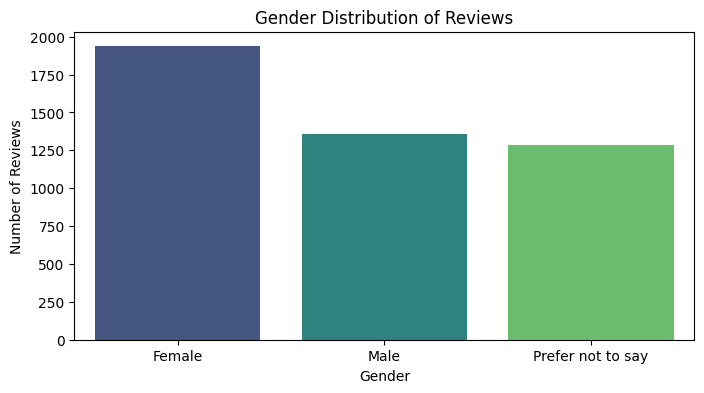

In [ ]:
gender_counts = consumer_data["Gender"].value_counts()

print(gender_counts) # getting the count of genders

# Gender Distribution
plt.figure(figsize=(8, 4))
sns.barplot(x = gender_counts.index, y = gender_counts.values, palette = "viridis")
plt.title("Gender Distribution of Reviews")
plt.ylabel("Number of Reviews")
plt.xlabel("Gender")
plt.show()

### Data Distribution and Relation

Visualizing data distribution in this case using the following fields: Rating, FullPrice, CurrentPrice, and IsPromoReview might be useful in terms of consumer data.

- Ratings -> customer satisfaction, product quality,  maybe some areas to improve (regarding low reviews).
- FullPrice and CurrentPrice -> full vs current for pricing strategy and/or purchasing behavior (how consumers might interact with discounts).
- IsPromoReview -> marketing strategy. Maybe which product is frequently promoted and how this might impract consumer behavior.

Understanding these distirbutions might help Nike understand how consumer make informed desicions based on popular products with highe ratings, price, and promotions. Other areas might include decisions in products development, marketing, pricing, sales, as well as customer preferences and behavior.

Nike products ratings:
5.0    4028
4.0     391
3.0      59
2.0      58
0.0      37
1.0       6
Name: Rating, dtype: int64


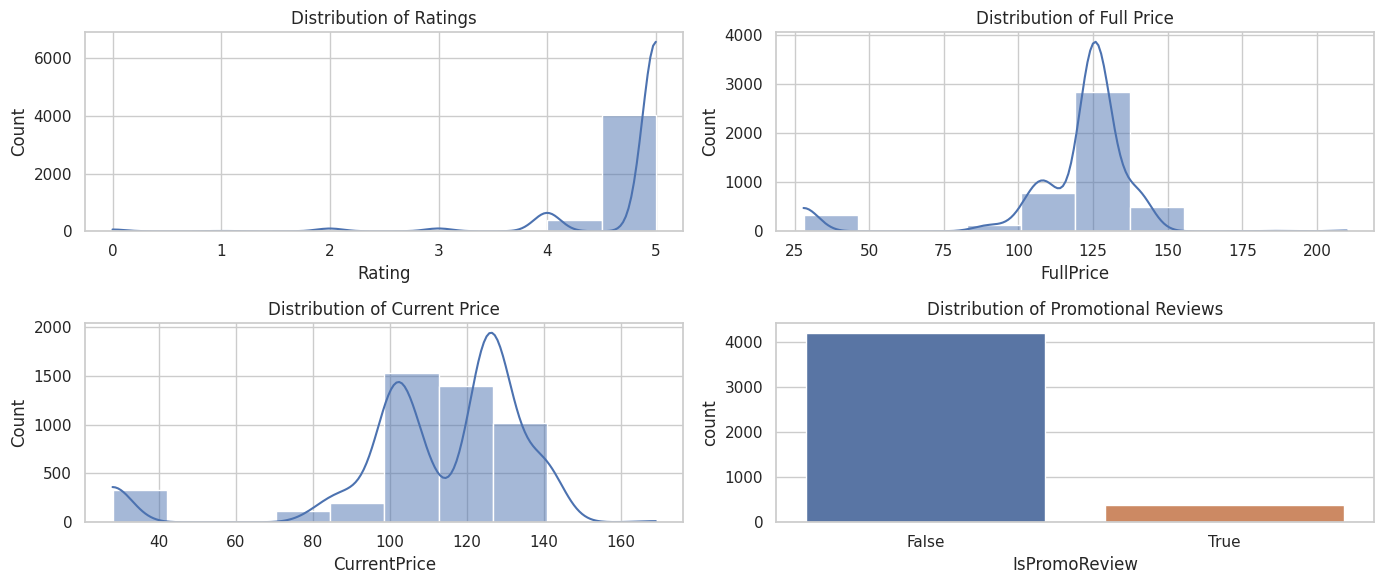

In [ ]:
# Source: https://www.geeksforgeeks.org/seaborn-style-and-color/
# Source: https://python-graph-gallery.com/20-basic-histogram-seaborn/

ratings = consumer_data["Rating"].value_counts()
print("Nike products ratings:")
print(ratings)

sns.set(style = "whitegrid") # whitegrid to help me distinguished data

# Histogram for "Rating"
plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
sns.histplot(consumer_data["Rating"], kde = True, bins = 10) # adding kde curve and bins set to 10
plt.title("Distribution of Ratings")

# Histogram for "FullPrice"
plt.subplot(2, 2, 2)
sns.histplot(consumer_data["FullPrice"], kde = True, bins = 10)
plt.title("Distribution of Full Price")

# Histogram for "CurrentPrice"
plt.subplot(2, 2, 3)
sns.histplot(consumer_data["CurrentPrice"], kde = True, bins = 10)
plt.title("Distribution of Current Price")

# Bar chart for "IsPromoReview" -> boolean values can't do hsitogram
plt.subplot(2, 2, 4)
sns.countplot(x = "IsPromoReview", data = consumer_data)
plt.title("Distribution of Promotional Reviews")

plt.tight_layout()
plt.show()

**Key points:**

- **Rating distribution:** This is a left skewed distribution. The ratings are concentrated towards the higher end of the scale (Rating 5 -> 4028 ratings vs Rating 4 -> 391 ratings) which means positive reception. The data show that customers really enjoy Nike products.

- **Full Price Distribution:** The distribution shows that the prices start around 25 and go up to 200 within this Nike Consumer data. However, most prices are set between 75 and 125. The bars around the tallest one are quite even on both sides meaning that there are a good number of products priced both a bit lower and a bit higher than most common prices. Also, there is a smaller peak around 150, meaning there is a second group of products that are commonly priced higher (special items perhaps?). This graph shows that there are different price ranges.

- **Current Price Distribution:** The graph shpows that there's a variety of prices, but they cluster around the two main peaks (near 100 and around 120). It seems that a lot of products are being sold at these two points. The pruces seem to range between 60 and 140 and fewer products outside this range. Also, there are fewer products priced around 40 and 160 (shown from the lower bars at these points).

- **Promo Review Distirbution:** This graph shows that most promo reviews are not promotional (False). The smallest bar shows that there are few promotional reviews. This might be good to Nike, because it indicated customers are motiviated to leave a review without needing to be promotional.

Member vs Non-Member counts: 
Yes    4034
No      545
Name: Member, dtype: int64


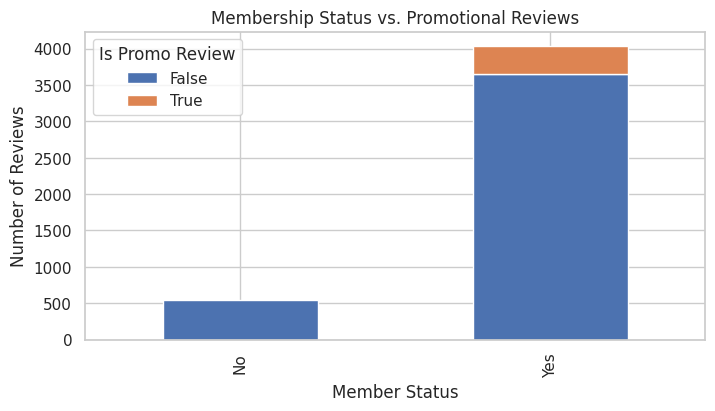

In [ ]:
# Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html

# Counting the number of promo reviews per membership status
member_count = consumer_data["Member"].value_counts()
member_promo_counts = consumer_data.groupby("Member")["IsPromoReview"].value_counts().unstack()

print("Member vs Non-Member counts: ")
print(member_count)

# Plotting the comparison of Member status with IsPromoReview
member_promo_counts.plot(kind = "bar", stacked = True, figsize=(8, 4))
plt.title("Membership Status vs. Promotional Reviews")
plt.ylabel("Number of Reviews")
plt.xlabel("Member Status")
plt.legend(title = "Is Promo Review")
plt.show()

The above graph shows that 4024 members left reviews while 545 non-members left reviews. The "Yes" bar shows that the vast majority of these reviews are non-promotional (blue), with a smaller portion being promotional (orange). It indicated that members are active in reviewing products, and even though they do participate in promotions, most of the reviews are not promo-driven. This is just a sample scenario, but if this is the case then the compnay will to increase some sort of membership engagement or eveluate its promotional campaings.

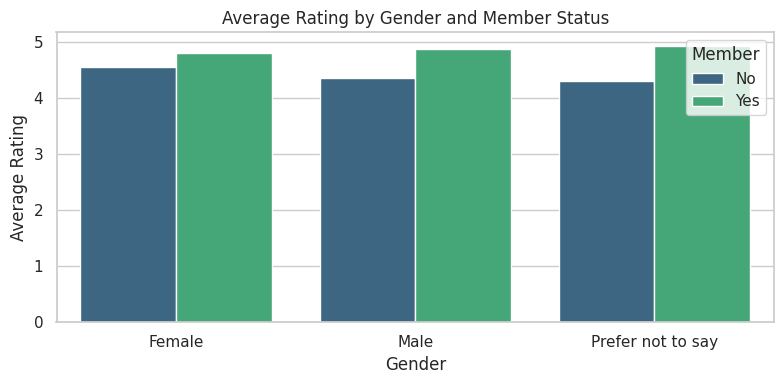

In [ ]:
# Group by -> Gender and Member and calculate the average Rating
grouped_data = consumer_data.groupby(["Gender", "Member"])["Rating"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.set(style = "whitegrid")
sns.barplot(x = "Gender", y = "Rating", hue = "Member", data = grouped_data, palette = "viridis") # Set2
plt.xlabel("Gender")
plt.ylabel("Average Rating")
plt.title("Average Rating by Gender and Member Status")

plt.legend(title = "Member", title_fontsize = "12")
plt.tight_layout()
plt.show()

The bar graph represents the average rating given by customers (grouped by their gender and member status).

The average rating provided by members and non-members. The green bar (Yes) represents the female, male, and prefer not to say members, and the blue bar (No) represents female, male, and prefer not to say non-members. It seemes that there's no significant difference in average rating between members and non-members across genders.

### Product Analysis

Nike Product Review Counts: 
Air Jordan 1 Mid                2310
Nike Air Max 90                  514
Air Jordan 1 High OG             496
Air Jordan 1 Low                 456
Nike Kawa                        326
Nike Blazer Mid '77              325
Nike Gamma Force                  79
Nike Air Max Correlate            48
Air Jordan 1 Mid SE               10
Nike Air VaporMax Plus            10
Nike Air Max Terrascape Plus       5
Name: Title, dtype: int64


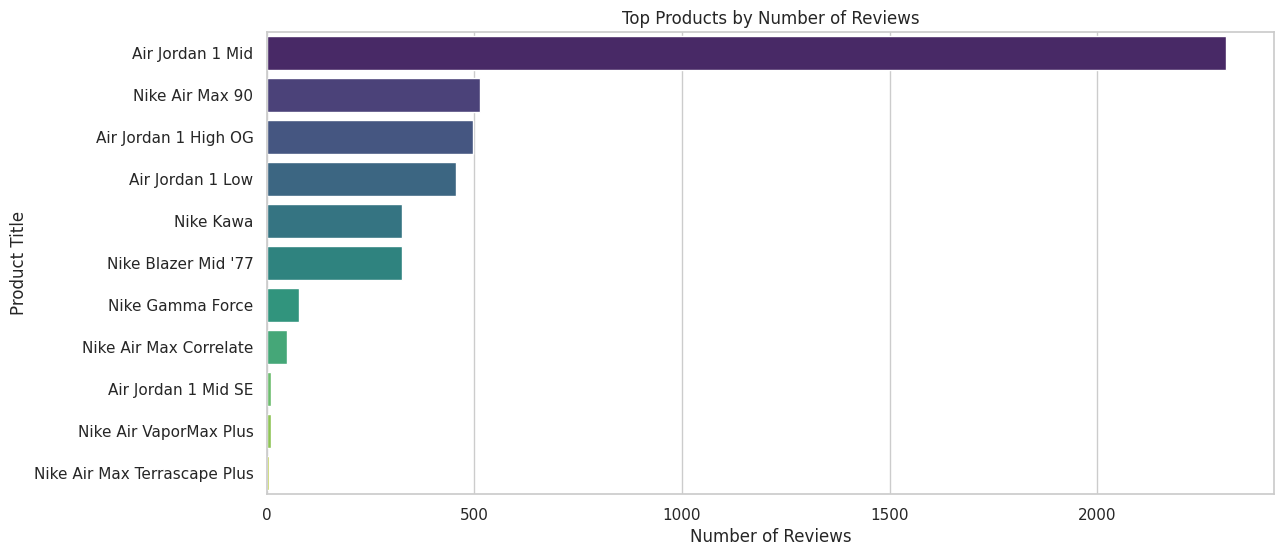

In [ ]:
top_products = consumer_data["Title"].value_counts() # getting the value counts for items
print("Nike Product Review Counts: ")
print(top_products)

plt.figure(figsize=(13, 6))
sns.barplot(x = top_products.values, y = top_products.index, palette = "viridis")
plt.title("Top Products by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Title")
plt.show()

The above graph shows that Air Jordan 1 Mid has been reviewd about 2,310 times making this the top item of all Nike shoes or products this data contains. Nike Air Max 90 comes in second place with 514 reviews and Air Jordan 1 High OG in thrid place with 496 reviews. The last three are: Air Jordan 1 Low with 456 reviews, Nike Kawa (sldies) with 326 reviews, and Nike Blazer Mid '77 with 325 reviews.




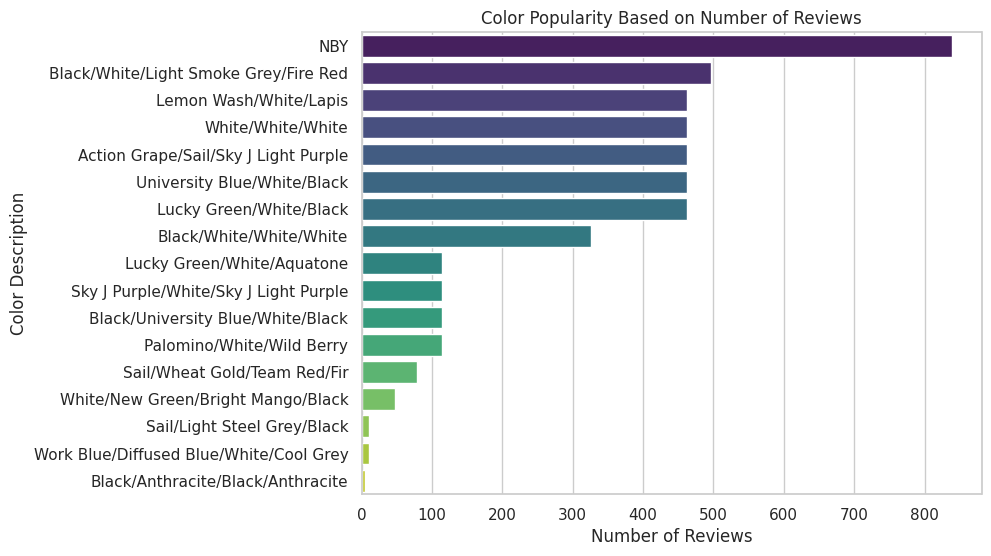

In [ ]:
# Color Popularity based on the number of reviews
color_popularity = consumer_data["ColorDescription"].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x = color_popularity.values, y = color_popularity.index, palette = "viridis")

plt.title("Color Popularity Based on Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Color Description")
plt.show()

**NBY is just "Nike By You" Custom Shoes.**

The most popular color description comes from NBY custom shoes followed by "Black/White/Light Smoke Grey/Fire Red".

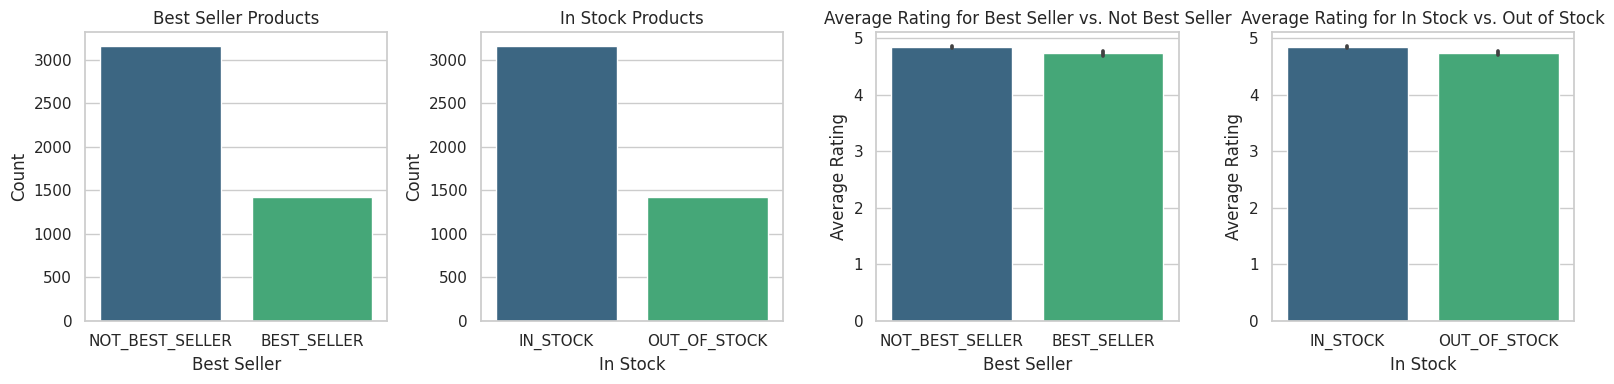

In [ ]:
plt.figure(figsize=(16, 4))

# Countplot for IS_BEST_SELLER field
plt.subplot(1, 4, 1)
sns.countplot(data = consumer_data, x = "IS_BEST_SELLER", palette = "viridis")
plt.xlabel("Best Seller")
plt.ylabel("Count")
plt.title("Best Seller Products")

# Countplot for IS_IN_STOCK field
plt.subplot(1, 4, 2)
sns.countplot(data = consumer_data, x = "IS_IN_STOCK", palette = "viridis")
plt.xlabel("In Stock")
plt.ylabel("Count")
plt.title("In Stock Products")

# Grouped bar plot for IS_BEST_SELLER vs. Rating fields
plt.subplot(1, 4, 3)
sns.barplot(data = consumer_data, x = "IS_BEST_SELLER", y = "Rating", palette = "viridis")
plt.xlabel("Best Seller")
plt.ylabel("Average Rating")
plt.title("Average Rating for Best Seller vs. Not Best Seller")

# Grouped bar plot for IS_IN_STOCK vs. Rating fields
plt.subplot(1, 4, 4)
sns.barplot(data = consumer_data, x = "IS_IN_STOCK", y = "Rating", palette = "viridis")
plt.xlabel("In Stock")
plt.ylabel("Average Rating")
plt.title("Average Rating for In Stock vs. Out of Stock")

plt.tight_layout()
plt.show()

The above graphs show that there are more non-best selling products than best sellers. Most of the products are in stock rather than out of stock while the average customer rating is high and similar for both the in stock and out of stock products. It basically shows that while best sellers are fewer, they are rated slightly better, and the stock status (in stock vs out of stock) does not affect the high customer ratings of products.

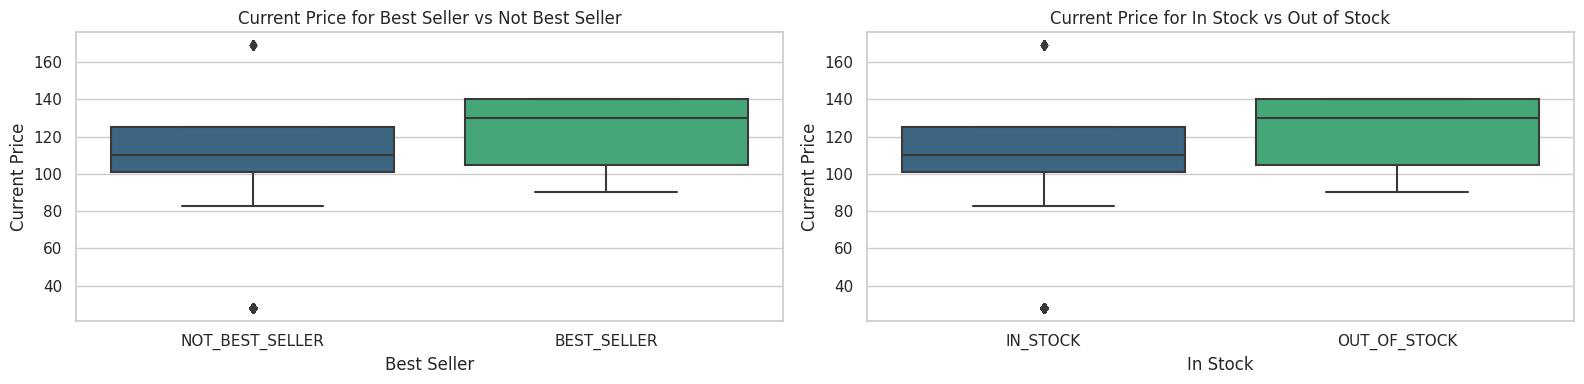

In [ ]:
plt.figure(figsize=(16, 4))

# Box plot for CurrentPrice by IS_BEST_SELLER field
plt.subplot(1, 2, 1)
sns.boxplot(data = consumer_data, x = "IS_BEST_SELLER", y = "CurrentPrice", palette = "viridis")
plt.xlabel("Best Seller")
plt.ylabel("Current Price")
plt.title("Current Price for Best Seller vs Not Best Seller")

# Box plot for CurrentPrice by IS_IN_STOCK field
plt.subplot(1, 2, 2)
sns.boxplot(data = consumer_data, x = "IS_IN_STOCK", y = "CurrentPrice", palette = "viridis")
plt.xlabel("In Stock")
plt.ylabel("Current Price")
plt.title("Current Price for In Stock vs Out of Stock")

plt.tight_layout()
plt.show()

The boxplots basically show that the blue boxes (NOT_BEST_SELLER and IN_STOCK products) have a lower median price comprared to the green boxes (BEST_SELLER and OUT_OF_STOCK" products). Both have outliers (diamnods), which are likely to be higher prices. In general, best sellers tend to be priced higher than non- best sellers while in stock products and out of stocks products have a broad range of prices (higher prices (diamonds) vs lower prices).

### Locations Across the US (Reviews)

The below map shows that each state is colored according to the number of reviews it has recieved, with the color intensity corresponding to the count. This choropleth map shows that the lighter colors represent fewer reviews and darker colors more reviews. I know I am working with a sample dataset, however a map like this could potentially help identify areas such as strong markets and potential growth areas (fewer reviews -> lighter colors) where Nike could focus its marketing and expansion efforts.

In [ ]:
# Source: https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e

consumer_data["State"] = consumer_data["Location"].apply(lambda x: x.split(', ')[0])

# Calculating the number of reviews per state
state_counts = consumer_data["State"].value_counts().reset_index()
state_counts.columns = ["State", "Counts"]

# choropleth map of the US
fig = px.choropleth(
    state_counts,
    locations = "State",
    locationmode = "USA-states",
    color = "Counts",
    color_continuous_scale = "Viridis_r",
    scope = "usa",
    title = "Distribution (Counts) of Reviews Across the USA"
)

fig.show()

Number of best selling Nikes Shoes vs Regular selling Nike Shoes: 
NOT_BEST_SELLER    3155
BEST_SELLER        1424
Name: IS_BEST_SELLER, dtype: int64


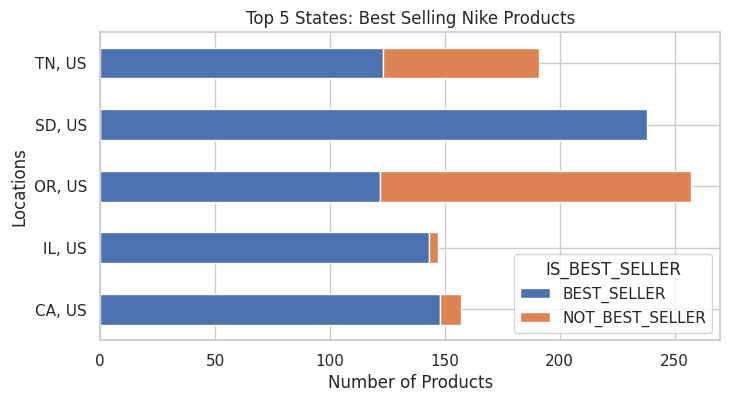

In [ ]:
Best_seller = consumer_data["IS_BEST_SELLER"].value_counts()
print("Number of best selling Nikes Shoes vs Regular selling Nike Shoes: ")
print(Best_seller)

# Filtering out the top 5 locations (best selling products)
top_seller_locations = consumer_data[consumer_data["IS_BEST_SELLER"] == "BEST_SELLER"]["Location"].value_counts().nlargest(5).index
top_locations = consumer_data[consumer_data["Location"].isin(top_seller_locations)] # filtering

# Counting the occurrences of best sellers vs not best sellers in each of these top locations
best_seller_counts_top_locations = top_locations.groupby(["Location", "IS_BEST_SELLER"]).size().unstack(fill_value = 0)

#plt.figsize=(10, 6)
best_seller_counts_top_locations.plot(kind = "barh", stacked = True, figsize=(8, 4))
plt.title("Top 5 States: Best Selling Nike Products")
plt.xlabel("Number of Products")
plt.ylabel("Locations")
plt.show()

The above graph shows the distribution of Nike products (shoes) in the top 5 states. California seems to have the highest number of both best selling and non-best selling products. The difference in Illinois is minimal, whereas in Oregon and Tenessee, the gap is much higher.

## Statistical Analysis

In [ ]:
consumer_data.describe()

,ID,Rating,FullPrice,EmployeePrice,CurrentPrice,Pid
count,4579.000000,4579.000000,4579.000000,4579.000000,4579.000000,4.579000e+03
mean,2294.236515,4.805198,116.773968,66.340830,110.568899,6.419562e+08
std,1323.796425,0.660341,26.980565,16.470366,27.450244,4.809463e+08
min,0.000000,0.000000,28.000000,16.800000,28.000000,1.014628e+07
25%,1149.500000,5.000000,110.000000,60.580000,100.970000,1.336568e+07
50%,2294.000000,5.000000,125.000000,75.000000,125.000000,1.010049e+09
75%,3440.500000,5.000000,125.000000,75.000000,125.000000,1.012357e+09
max,4586.000000,5.000000,210.000000,101.380000,168.970000,1.012365e+09


- The average rating is high at approx 4.81 (positive -> most products have high ratings).

- Full prices ->  range from 28 (min) to 210 (max).

- Current prices -> The average current price is $110.57. The minimum price matches the full price of 28, but the maximum current price is less than the maximum full prices at 168.97.

The summary statistics of the numerical values represent a positive reception of Nike products as well as a considerable range in full and current prices.

### Correlation HeatMap

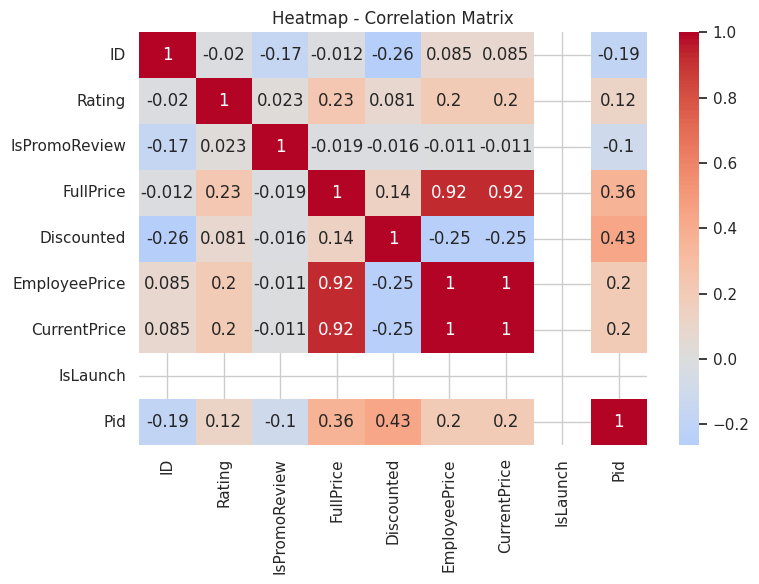

In [ ]:
# Source: https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14
# Source: https://stats.stackexchange.com/questions/392517/how-can-one-interpret-a-heat-map-plot
# Source: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e


corr_matrix = consumer_data.corr() # calculating correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", center = 0) # heatmap
plt.title("Heatmap - Correlation Matrix")
plt.tight_layout()
plt.show()

Fields such as ID, Rating, and IsLaunch have very weak correlations with other columns (no linear relationship with other fields).

- 1 -> perfect positive correlation.
- -1 -> perfect negative correlation.
- 0 -> no correlation.

The heat map shows that "FullPrice" and "EmployeePrice" have a very storng positive correlation of 0.92 (maybe when full price of a product increases, then the employee price tends to increase as well).

"FullPrice" and "CurrentPrice" shows a very strong positive correlation of 0.92 stating that the current price is likely to increase with an increase of the full price. "IsPromoReview" doesn't seem to have any storng correlations with other variables. This might imply that wether is promotional or not doesn't strongly affect the pricing or ratings.

### Time Series Analysis

As I mentioned beofre, it is important to know that after carefully analyzing the Review Date column, I noticed that the data had no chronological order whatsoever. Also, the year 2021 is missing, there's no 2021 just -> 2023, 2022, 2020, 2019, and 37 missing values. I know this can be a bit trciky if I plan to do some kind of trend or time series analysis. I will replace those missing values with "NaT", because I don't want my experimentations to lead to singificant inaccuracies in trend analysis.

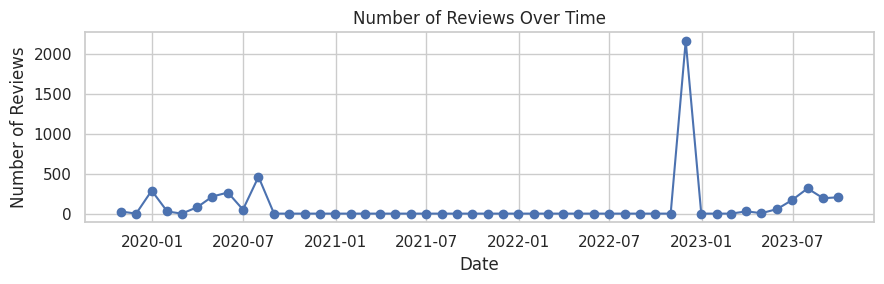

In [ ]:
# Source: https://www.geeksforgeeks.org/python-pandas-dataframe-resample/
# Source: https://towardsdatascience.com/resample-function-of-pandas-79b17ec82a78
# Source: https://www.geeksforgeeks.org/numpy-size-function-python/
# Source: https://www.datacamp.com/tutorial/matplotlib-time-series-line-plot
# Spurce: https://www.geeksforgeeks.org/how-to-plot-a-time-series-in-matplotlib/

reviews_per_month = consumer_data.resample("M", on = "Review Date").size() # resampling and counting by month

plt.figure(figsize=(9, 3))
plt.plot(reviews_per_month.index, reviews_per_month.values, marker = "o", linestyle = "-")
plt.title("Number of Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.tight_layout()
plt.show()

I initially tried to tired to analyze the reviews by date, however it was a mess. The above graph represents reviews over time with data aggregated by month (This helps analyzing the total number of reviews for each month). This makes it easier to analyze. Since I sorted the data by date and replacing missing values with "NaT" ensuring that the time series doe snot inclyde these gaps as random zeros which could distort the analysis. There is a significant spike around 2022 goes up compared to other months. Maybe customers left reviews in a short period of time, reason for the anomaly.

Time Series Analysis might not be that useful while suing this dataset.

## Predictive Analytics (Basic Natural Language Processing)

### NLP - Sentiment Analysis



In [ ]:
stop_words = nltk.corpus.stopwords.words("english")

def normalize_document(doc): # coming from Intro to Intro NLP for Data Science class
    doc = emoji.demojize(doc) # translating emojis into text
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A) # removing characters that are not aplanumeric + whitespaces, case insensitive
    doc = doc.lower() # to lower case
    doc = doc.strip() # removing white spaces from text
    tokens = nltk.word_tokenize(doc) # splitting into individual words (tokens)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

Using TextBlob to extract sentiment.

In [ ]:
# TextBlob for sentiment computation -> # coming from Intro to Intro NLP for Data Science Final Project
# Source: https://www.youtube.com/watch?v=qTyj2R-wcks

# to classify sentiment into labels based on overall emtions tone within the text
def polarity(txt): # polarity function
    try:
        return TextBlob(txt).sentiment.polarity
    except:
        return None

# if text is opinionated or factual
# if the text expresses personal opinions, feelings, emotions etc
# 0 -> facts
# 1 -> opinion
def subjectivity(txt): # subjectivity function
  try:
      return TextBlob(txt).sentiment.subjectivity
  except:
        return None

def analyze(x): # analyzing functon
        if x < 0:
            return "negative"
        elif x == 0:
            return "neutral"
        else:
            return "positive"

Cleaning Review column:

In [ ]:
nlp_df = consumer_data

empty_reviews_count = nlp_df[nlp_df.Review.str.strip() == ''].shape[0] # checking for empty reviews or reviews with only whitespace
print("Number of empty reviews:", empty_reviews_count)

norm_corpus = normalize_corpus(nlp_df["Review"]) # normalizing the Review column using normalize_corpus
nlp_df["Clean Review"] = norm_corpus # creating a new column with cleaned Reviews
nlp_df = nlp_df[["Review", "Clean Review"]] # selecting review columns
nlp_df = nlp_df.replace(r'^(\s?)+$', np.nan, regex = True) # replacing empty strings or strings with only whitespace with NaN

nlp_df_cleaned = nlp_df.dropna().reset_index(drop = True) # dropping rows with NaN values and resetting the index

reviews = nlp_df_cleaned[["Review", "Clean Review"]]
reviews.head()

Number of empty reviews: 0


,Review,Clean Review
0,Cute but small\nI bought these for my son and ...,cute small bought son really excited get howev...
1,Cute but small\nI bought these for my son and ...,cute small bought son really excited get howev...
2,Cute but small\nI bought these for my son and ...,cute small bought son really excited get howev...
3,Cute but small\nI bought these for my son and ...,cute small bought son really excited get howev...
4,Cute but small\nI bought these for my son and ...,cute small bought son really excited get howev...


In [ ]:
reviews.to_csv("NikeReviews.csv", index = False) # I don't want to touch the original file

In [ ]:
sentiment = pd.read_csv("NikeReviews.csv")

sentiment["polarity"] = sentiment["Clean Review"].apply(polarity) # using polarity function
sentiment["subjectivity"] = sentiment["Clean Review"].apply(subjectivity) # using subjectivity function
sentiment["sentiment"] = sentiment["polarity"].apply(analyze) # applying the analyze function
sentiment = sentiment[["Clean Review", "polarity", "subjectivity", "sentiment"]]
sentiment.head()

,Clean Review,polarity,subjectivity,sentiment
0,cute small bought son really excited get howev...,0.311111,0.694444,positive
1,cute small bought son really excited get howev...,0.311111,0.694444,positive
2,cute small bought son really excited get howev...,0.311111,0.694444,positive
3,cute small bought son really excited get howev...,0.311111,0.694444,positive
4,cute small bought son really excited get howev...,0.311111,0.694444,positive


In [ ]:
sentiment.to_csv("NikeSentiment.csv", index = False) # csv containing TextBlob predicted sentiment

Due to data quality, which is a huge factor in this analysis, is not that good. The data has a lot of duplicated reviews (the exact same reviews with the exact same sentiments predicted by TextBlob), so I am creating a new variables that contains no duplicates called "sentiment_no_duplicates". I am doing this because I want to preserve the sentiment diversity. This new datatframe aggregates the data by grouping it by "Clean Review" and selects the first sentiment encountered within each group.

In [ ]:
# Merging the sentiment dataframe with sentiment_no_duplicates based on the clean reviews
sentiment_no_duplicates = sentiment.groupby('Clean Review')[['polarity', 'subjectivity', 'sentiment']].first().reset_index()

positive    195
negative      5
neutral       4
Name: sentiment, dtype: int64


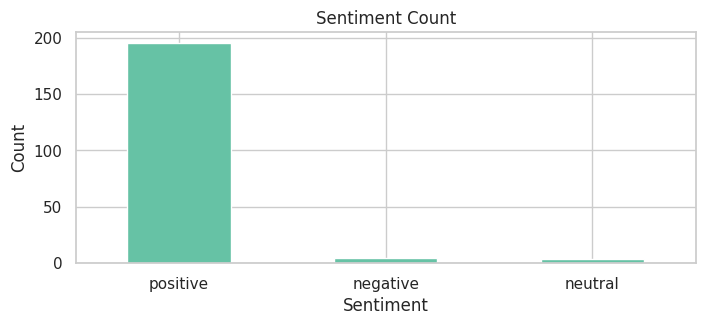

In [ ]:
sentiment_count = sentiment_no_duplicates["sentiment"].value_counts()
print(sentiment_count)

plt.figure(figsize=(8, 3))
sentiment_count.plot(kind = "bar", colormap = "Set2")
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

Checking out those negative and neutral sentiments:

In [ ]:
negative_neutral_rows = sentiment_no_duplicates[(sentiment_no_duplicates["sentiment"] == "negative") | (sentiment_no_duplicates["sentiment"] == "neutral")]
negative_neutral_rows

,Clean Review,polarity,subjectivity,sentiment
0,1010 havent even put 10,0.000000,0.000000,neutral
21,bequemer sneaker sind meine ersten sportschuhe...,0.000000,0.000000,neutral
32,classics air max 90s classics always stylish g...,-0.053333,0.666667,negative
41,comfy recommend ordering half size bigger run ...,-0.048810,0.400595,negative
45,cute run small ordered size 8c daughter isnt s...,-0.020833,0.591667,negative
93,laker pro laker proof look like shoes lakers w...,-0.012500,0.575000,negative
139,none,0.000000,0.000000,neutral
180,smilingfacewithhearteyes cutewhiteheartblackhe...,0.000000,0.000000,neutral
201,would recommend productno disappointed okay ov...,-0.021429,0.564286,negative


**Word Cloud -> for the most frequently used word within "Clean Review" column.**

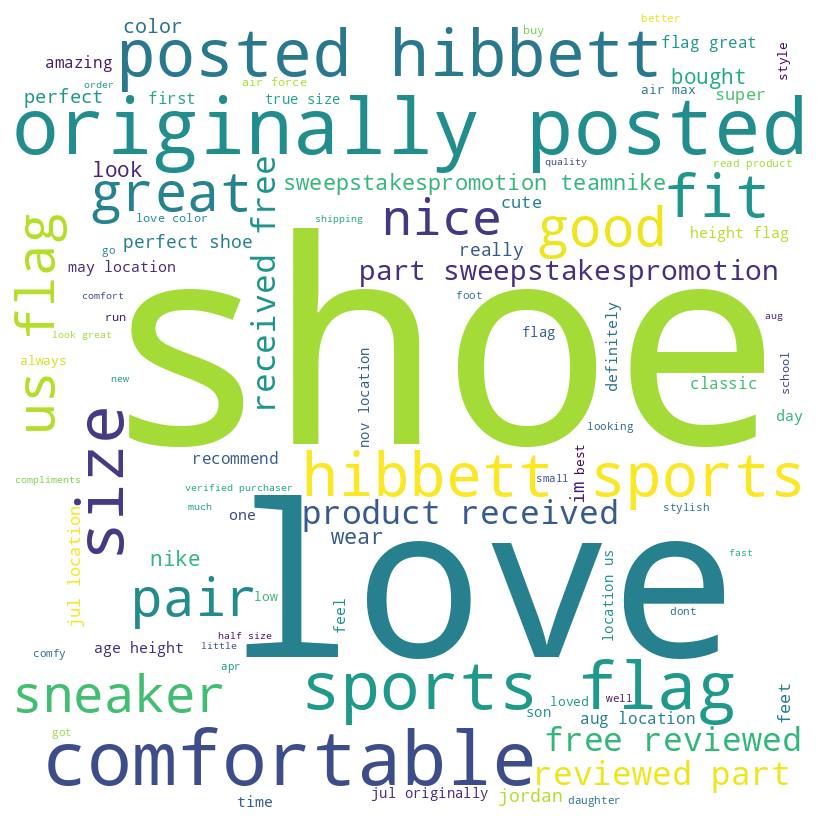

In [ ]:
# Source: https://www.datacamp.com/tutorial/wordcloud-python

string_text = " ".join(review for review in sentiment_no_duplicates["Clean Review"]) # NLP class -> all cleaned reviews into a single string

# Creating a WordCloud object
wordcloud = WordCloud(width = 800, height = 800, background_color = "white", min_font_size = 10).generate(string_text)
#wc = WordCloud(width = 600, height = 600, background_color = "white").generate(string_text)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# I want to focus on the importance and frequency of the words -> TfidfVectorizer()
# lest common words -> higher TFIDF score
# most common words -> the, and, is etc get a much lower TFIDF score
# this will help with demensionality reduction
nlp_features = TfidfVectorizer() # feature engineering for text data

Since I am doing a basic logistic regression model to predict the three sentiment labels (classification) I will not be using "polarity" and "subjectivity" functions. Feature engineering is done using the TfidfVectorizer() function by focusing in the most important words and frequency as well as dimensionality reduction.

In [ ]:
X = nlp_features.fit_transform(sentiment_no_duplicates["Clean Review"])  # feature matrix containing input features used for classification
y = sentiment_no_duplicates["sentiment"]  # target labels positive, neutral, negative ( I want to predict this)

In [ ]:
# using stratify to make sure each class is presented in both datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
# Source: https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

nlp_logistic = LogisticRegression(multi_class = "multinomial", solver = "lbfgs") # solver for multi class problems
nlp_logistic.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [ ]:
y_pred_train = nlp_logistic.predict(X_train) # train features
print("Accuracy Score Logistic Regression:", accuracy_score(y_train, y_pred_train)) # true labels, predicted labels

Accuracy Score Logistic Regression: 0.9570552147239264


Tetsing on unseen data labels:

In [ ]:
y_pred = nlp_logistic.predict(X_test)
print("Accuracy Score Logistic Regression Testing Labels:", accuracy_score(y_test, y_pred))

Accuracy Score Logistic Regression Testing Labels: 0.9512195121951219


Since we are dealing with a case of class imabalance due to the nature of the data, I will be also using the F1 score to "analyze" my logistic regression results. The reason is because accuracy might be misleading at this point. Since this is a basic model with no extra paramaters and cross validation, I will just go ahead and calculate the F1 score which is useful for multi classification tasks. I have an extreme case of imbalance in my dataset.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
f1_score_micro = f1_score(y_test, y_pred, average = "micro")
f1_score_macro = f1_score(y_test, y_pred, average = "macro")
f1_score_weighted = f1_score(y_test, y_pred, average = "weighted")

# Print the F1 scores
print("Micro Averaged F1 Score Logistic Regression Model:", f1_score_micro)
print("Macro Averaged F1 Score Logistic Regression Model:", f1_score_macro)
print("Weighted Averaged F1 Score Logistic Regression Model:", f1_score_weighted) # overall performance

Micro Averaged F1 Score Logistic Regression Model: 0.9512195121951219
Macro Averaged F1 Score Logistic Regression Model: 0.325
Weighted Averaged F1 Score Logistic Regression Model: 0.9274390243902438


The micro average shows that my model has an overall performance regarding correctness and it seems to provide a good balance between individual class performance/importance.

The macro average in the other hand, seems to show that there might be variations in performance across different sentiment classes.

The weighted average take sinto account class imbalance and provides kind of like a more balancedassessment of the overall model performance. The following classification report will show more insights.

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         1
    positive       0.95      1.00      0.97        39

    accuracy                           0.95        41
   macro avg       0.32      0.33      0.33        41
weighted avg       0.90      0.95      0.93        41



Limited support for the "neutral" and "negative" classes is lower.

In [ ]:
logistic_results = pd.DataFrame({"Clean Review": sentiment.loc[y_test.index, "Clean Review"],
                                 "TextBlob Sentiment": y_test,
                                 "Predicted Sentiment LR": y_pred})

logistic_results.head()

,Clean Review,TextBlob Sentiment,Predicted Sentiment LR
40,colors would get shoe comfy love porsherb34828...,positive,positive
2,cute small bought son really excited get howev...,positive,positive
122,cute run small ordered size 8c daughter isnt s...,positive,positive
94,soft comfy stylish comfy little babies love de...,positive,positive
14,cute small bought son really excited get howev...,positive,positive


In [ ]:
logistic_results.to_csv("sentiment_logistic.csv", index = False)

In [ ]:
logistic_results["Correct Prediction"] = logistic_results["TextBlob Sentiment"] == logistic_results["Predicted Sentiment LR"]

incorrect_predictions = logistic_results[~logistic_results["Correct Prediction"]] # filter to show only incorrect predictions

incorrect_count = len(incorrect_predictions) # counting incorrect predictions
print("Count of Incorrect Predictions:", incorrect_count)
print("Incorrect Predictions:")
incorrect_predictions

Count of Incorrect Predictions: 2
Incorrect Predictions:


,Clean Review,TextBlob Sentiment,Predicted Sentiment LR,Correct Prediction
180,sandals way smaller actual size unfortunately ...,neutral,positive,False
93,soft comfy stylish comfy little babies love de...,negative,positive,False


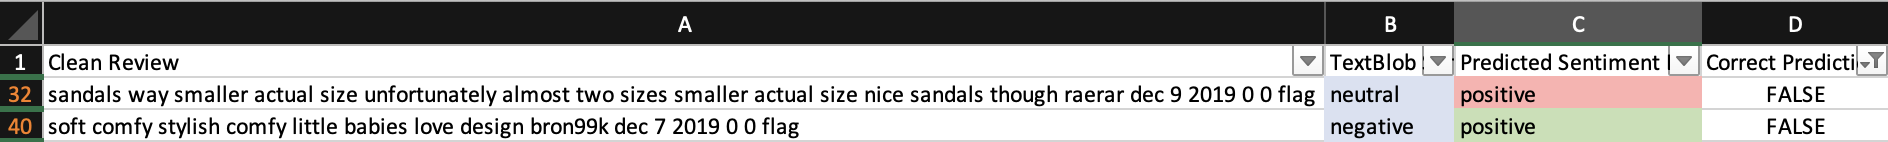

We know we are dealing with a low quality datasets that suffers from class imbalance, however the logistic regression model correctly predicted "positive" label for one of the reviews as shown in the above image. It also misclassified (as seen in red) one of the sentiments.